In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from service.app_api.features.extractor import FeatureExtractor
from tuning.optuna_tuning import OptunaTuner
from configs import utils

from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score
import optuna
import wandb

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


In [2]:
try:
    customers, sales = joblib.load('customers.joblib'), joblib.load('sales.joblib')
except:
    customers, sales = pd.read_excel('ucy_eko_data.xlsx', sheet_name='smile_customers'), pd.read_excel('ucy_eko_data.xlsx', sheet_name='smile_sales')
    joblib.dump(customers, 'customers.joblib')
    joblib.dump(sales, 'sales.joblib')

In [9]:
fe = FeatureExtractor(target_month=3, n_purchases=3, perform_split=True, generation_type='categorical', filtering_set='customers', period=60, subperiod=15)
X_train, X_test, y_train, y_test = fe.transform(sales=sales, customers=customers)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/fedorturchenko/.cache/huggingface/token
Login successful
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Successfully logged out.


## Default Parameters Performance

In [18]:
cat = CatBoostClassifier(
    cat_features=[col for col in X_train.columns if 'last_purchase_share' not in col],
    random_seed=571,
    scale_pos_weight=(y_train==0).sum()/(y_train==1).sum()
)

In [19]:
cat.fit(X_train, y_train)
train_preds = cat.predict(X_train)
test_preds = cat.predict(X_test)

Learning rate set to 0.038782
0:	learn: 0.6721945	total: 24.2ms	remaining: 24.2s
1:	learn: 0.6523733	total: 48.2ms	remaining: 24s
2:	learn: 0.6348838	total: 71.7ms	remaining: 23.8s
3:	learn: 0.6183729	total: 92.8ms	remaining: 23.1s
4:	learn: 0.6045240	total: 114ms	remaining: 22.6s
5:	learn: 0.5909936	total: 134ms	remaining: 22.2s
6:	learn: 0.5788511	total: 157ms	remaining: 22.2s
7:	learn: 0.5675873	total: 179ms	remaining: 22.1s
8:	learn: 0.5575894	total: 200ms	remaining: 22.1s
9:	learn: 0.5489920	total: 226ms	remaining: 22.4s
10:	learn: 0.5408458	total: 252ms	remaining: 22.7s
11:	learn: 0.5339591	total: 267ms	remaining: 22s
12:	learn: 0.5271254	total: 289ms	remaining: 21.9s
13:	learn: 0.5208985	total: 309ms	remaining: 21.8s
14:	learn: 0.5150281	total: 328ms	remaining: 21.6s
15:	learn: 0.5097675	total: 351ms	remaining: 21.6s
16:	learn: 0.5046205	total: 373ms	remaining: 21.5s
17:	learn: 0.5002382	total: 393ms	remaining: 21.4s
18:	learn: 0.4965907	total: 411ms	remaining: 21.2s
19:	learn: 

In [20]:
print(classification_report(y_train, train_preds))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87     16722
           1       0.60      0.81      0.69      5575

    accuracy                           0.82     22297
   macro avg       0.76      0.81      0.78     22297
weighted avg       0.84      0.82      0.82     22297



In [21]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86      5519
           1       0.59      0.78      0.67      1914

    accuracy                           0.80      7433
   macro avg       0.75      0.80      0.77      7433
weighted avg       0.83      0.80      0.81      7433



<BarContainer object of 29 artists>

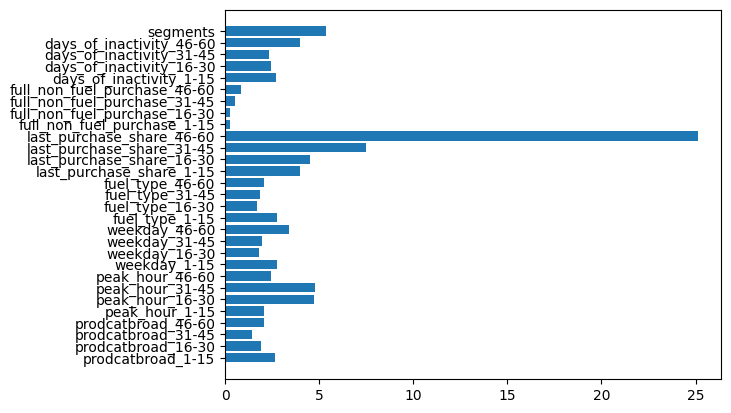

In [8]:
importances = cat.feature_importances_
names = cat.feature_names_
plt.barh(names, importances)

## Parameters tuning

In [10]:
cb_op = OptunaTuner(
    CatBoostClassifier,
    accuracy_score,
    direction='maximize',
    random_state=571,
    verbose=0,
    cat_features=[col for col in X_train.columns if 'last_purchase_share' not in col],
    scale_pos_weight=(y_train==0).sum()/(y_train==1).sum()
)
cb_op.fit(
    100, X_train, y_train, X_test, y_test,
    ('learning_rate', 'float', 1e-3, 1e-1, {'log': True}),
    ('depth', 'int', 2, 11),
    ('iterations', 'int', 100, 1000),
    ('subsample', 'float', 0.05, 1.0),
    ('colsample_bylevel', 'float', 0.05, 1.0),
    ('min_data_in_leaf', 'int', 1, 100),
)

In [ ]:
optuna.visualization.plot_optimization_history(cb_op.study)

In [ ]:
config = cb_op.model.get_params()
cat = CatBoostClassifier(**config)

# Create w&b run for the training set
with utils.init_wandb_run(
    name=f'categorical_features_optuna_subperiod_{fe.subperiod}',
    model=CatBoostClassifier,
    config=config,
    target_month=fe.target_month,
    group='parameters_tuning',
    job_type='tuning_train'
) as run:

    cat.fit(X_train, y_train)
    train_preds = cat.predict(X_train)

    rep = utils.parse_classification_report(
        classification_report(y_train, train_preds, output_dict=True)
    )

    metadata = {
        'experiment': {
            'name': run.name,
        },
        'performance_report': rep,
        'config': config
    }

    artifact = wandb.Artifact(
        name=f'report_train',
        type='performance_metric',
        metadata=metadata
    )
    run.log_artifact(artifact)
    run.finish()

# Create w&b run for the test set
with utils.init_wandb_run(
    name=f'categorical_features_optuna_subperiod_{fe.subperiod}',
    model=CatBoostClassifier,
    config=config,
    target_month=fe.target_month,
    group='parameters_tuning',
    job_type='tuning_test'
) as run:
    test_preds = cat.predict(X_test)
    rep = utils.parse_classification_report(
        classification_report(y_test, test_preds, output_dict=True)
    )

    metadata = {
        'experiment': {
            'name': run.name,
        },
        'performance_report': rep,
        'config': config
    }

    artifact = wandb.Artifact(
        name=f'report_test',
        type='performance_metric',
        metadata=metadata
    )
    run.log_artifact(artifact)
    run.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
